# Implementierung

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import linalg

## Quadratur-Formel

Exakte Quadratur:

\begin{align*}
    Q(f)
    :=
    \frac{1}{2 \pi i}
    \int_{|\lambda| = R}
    f(\lambda)
    d \lambda
\end{align*}

Approximative Quadrature:

\begin{align*}
    Q_m(f)
    :=
    \frac{R}{m}
    \sum_{\nu=0}^{m-1}
    \omega_m^\nu f(R \omega_m^\nu),
    \quad
    \omega_m
    :=
    \exp
    \left(
        \frac{2 \pi i}{m}
    \right )
\end{align*}

In [2]:
# quadrature node
omega = lambda m: np.exp(2 * np.pi * 1j / m)

# quadrature on 0-centered ball with radius R
Q_zero = lambda m, f, R: R / m * sum([
    omega(m) ** nu * f(R * omega(m) ** nu)
    for nu in range(m)
])

# quadrature on z-centered ball with radius R
Q = lambda m, f, R, z: Q_zero(m, lambda x: f(x + z), R)

## Integralmethode

1. Berechne $A_0 \in \mathbb{C}^{N \times j}$

\begin{align*}
    A_1
    :=
    \frac{1}{2 \pi i}
    \int_\Gamma
    \lambda A(\lambda)^{-1} \hat{V}
    d \lambda
    \in \mathbb{C}^{N \times j}
\end{align*}

2. Berechne reduzierte Singulärwertzerlegung $A_0 = \tilde{V} \Sigma \tilde{W}^\ast$ mit $J$ Singulärwerten

3. Berechne $A_1 \in \mathbb{C}^{N \times j}$

\begin{align*}
    A_1
    :=
    \frac{1}{2 \pi i}
    \int_\Gamma
    \lambda A(\lambda)^{-1} \hat{V}
    d \lambda
    \in \mathbb{C}^{N \times j}
\end{align*}

4. Berechne die Eigenwerte der Matrix $\tilde{V} A_1 \tilde{W} \Sigma^{-1} \in \mathbb{C}^{j \times j}$ (z.B. mit QR-Verfahren)

In [3]:
def integral_method(A, N, j, m, R, z, tol, debug = False):

    """
    A ... matrix-function
    N ... number of rows/columns of A(lambda)
    j ... number of expected eigen values in ball B_R(z) ...
    m ... number of quadrature nodes
    R ... ball-radius
    z ... ball-center
    tol ... tolerance for singular value decomposition reduction
    """

    # random matrix
    V_hat = np.random.random((N, j))

    # ------------------------ #
    # step 1: calculate A_0 and A_1

    # integrand of A_0
    def f_0(lamda):

        LU, piv = linalg.lu_factor(A(lamda))

        return np.array([
            linalg.lu_solve((LU, piv), V_hat[:, i])
            for i in range(j)
        ]).T

    # integrand of A_1
    f_1 = lambda lamda: lamda * f_0(lamda)

    # apply quadrature formula to integrand for A_0 and A_1
    A_0 = Q(m, f_0, R, z)
    A_1 = Q(m, f_1, R, z)

    # ------------------------ #
    # step 3: calculate and reduce singular value decomposition to J singular values

    # get full i.e. unreduced singular value decomposition
    V_tilde_full, Sigma_full, W_tilde_full = linalg.svd(A_0, full_matrices = False)
    
    # mask for SVD reduction (kill zero values)
    mask = np.abs(Sigma_full) > tol

    # apply mask i.e. reduce SVD
    Sigma_reduced = Sigma_full[mask]
    V_tilde_reduced = V_tilde_full[:, mask]
    W_tilde_reduced = W_tilde_full[mask, :]

    # ------------------------ #
    # step 3: calculate eigen values (e.g. via QR-method)

    eigen_values = linalg.eigvals(
        V_tilde_reduced.conj().T @ A_1 @ W_tilde_reduced.conj().T @ np.diag(Sigma_reduced ** (-1))
    )

    if debug:
        return (
            eigen_values,
            V_hat,
            f_0, f_1,
            A_0, A_1,
            V_tilde_full, Sigma_full, W_tilde_full,
            V_tilde_reduced, Sigma_reduced, W_tilde_reduced,
        )
    else:
        return eigen_values

# Tests

Um die exakten und approximierten Eigenwerte zu plotten, verwenden wir `plot_complex`.

In [4]:
def plot_complex(number_matrix, title = None, legend = None, size_figure = (15, 15), size_dots = plt.rcParams['lines.markersize'] ** 2):

    fig = plt.figure(figsize = size_figure)

    for number_array in number_matrix:

        plt.scatter(
            *np.array([
                [number.real, number.imag]
                for number in number_array
            ]).T,
            s = size_dots
        )

    plt.grid(linestyle = ':')
    plt.xlabel('$\Re$')
    plt.ylabel('$\Im$')

    if title != None:
        plt.suptitle(title)

    if legend != None:
        plt.legend(legend)

    fig.show()

## Konstante Matrix-Funktionen aus ähnlichkeits-tranformierten Diagonalmatrizen

Um die Funktion `integral_method` zu testen, konstruieren wir einfache Matrix-Funktionen.

Die wohl einfachsten Matrix-Funktion sind konstant gleich einer Matrix.
Die Eigenwerte von Diagonalmatrizen stehen direkt in ihrer Diagonale.
Ähnliche Matrizen haben dieselben Eigenwerte.

Wir werden also für gegebene Eigenwerte `eigen_values` eine Diagonalmatrix `diagonal_matrix` erstellen und diese mit irgendeiner regulären Matrix `T` bzw. ihrer Inversen `T.inv()` von links und rechts multiplizieren.
Die dadurch entstandene Matrix `A_const` hat also die Eigenwerte `eigen_values`.
Jetzt müssen wir `A_const` nur noch zu einer konstanten Funktion `A` machen.

In [5]:
# ---------------------------------------------------------------- #

def test_1_matrix(eigen_values):

    # diagonal matrix with eigen values in diagonal
    diagonal_matrix = np.diag(eigen_values)

    # random transformation matrix
    T = np.random.random(diagonal_matrix.shape)

    # arbitrary matrix with known eigen values
    A = T @ diagonal_matrix @ linalg.inv(T)

    # function A
    A = lambda lamda: T @ diagonal_matrix @ linalg.inv(T) - lamda * np.eye(N)

    return A

# ---------------------------------------------------------------- #

def test_1_get_error_array(eigen_values_exact, N, j, m_array, R, z, tol):

    # get dummy matrix from given exact eigen values
    A = test_1_matrix(eigen_values_exact)

    error_array = []

    for m in m_array:

        # apply integral method
        eigen_values_approx = integral_method(A, N, j, m, R, z, tol)

        # calculate maximum error of eigen value approximation
        error = max([
            min([
                np.abs(approx - exact)
                for exact in eigen_values_exact
            ])
            for approx in eigen_values_approx
        ])

        # append error to array
        error_array.append(error)

    return error_array

# ---------------------------------------------------------------- #

def test_1_plot_error_array(m_array, error_array, reference_order):

    s = reference_order
    reference_label = 'reference:' + ' ' + r'$\mathcal{O}(m^{{{-' + str(s) + r'}}})$'

    fig = plt.figure(figsize = (15, 10))

    plt.loglog(m_array, error_array,      label = 'approximation error')
    plt.loglog(m_array, 1 / m_array ** s, label = reference_label)

    plt.legend()
    plt.xlabel('$m$')
    plt.grid(linestyle = ':')

    fig.show()

# ---------------------------------------------------------------- #

### Einzelne Werte

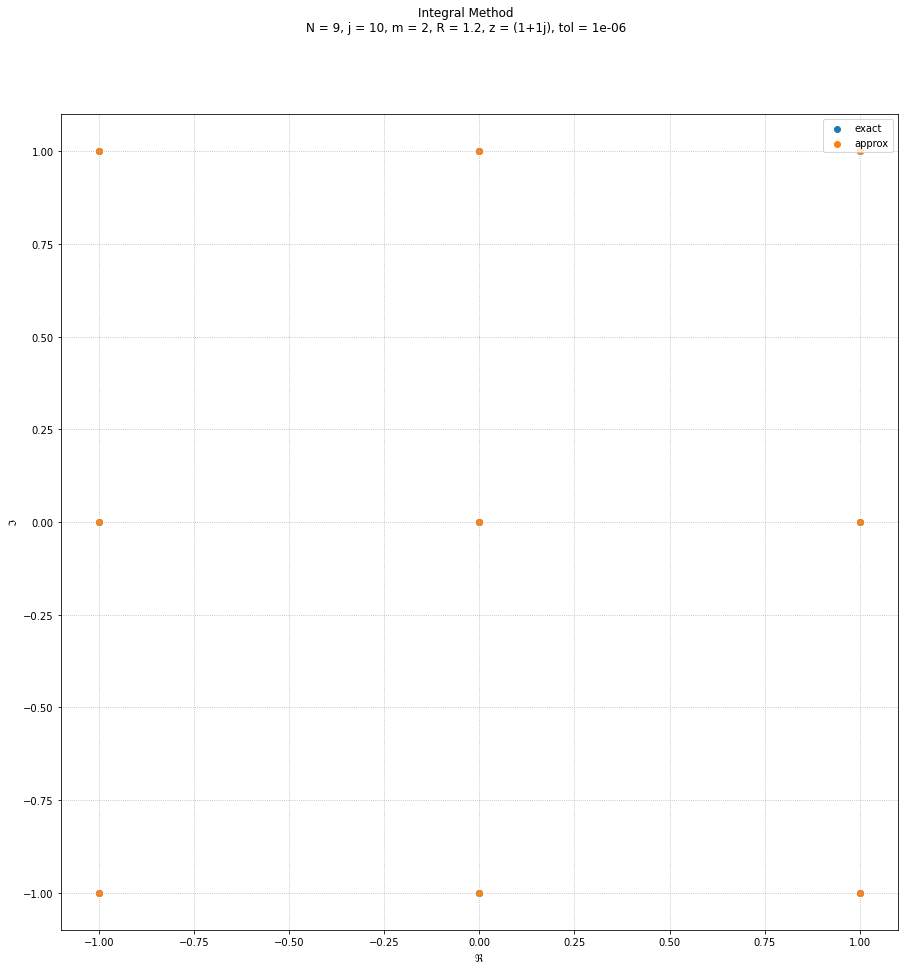

In [6]:
eigen_values_exact = [1 + 1j, 1 - 1j, -1 + 1j, -1 - 1j, 0, 1, 1j, -1j, -1]

A = test_1_matrix(eigen_values_exact)
N = len(eigen_values_exact)
j = 10
m = 2
R = 1.2
z = 1 + 1j
tol = 1e-6

eigen_values_approx = integral_method(A, N, j, m, R, z, tol)

title = 'Integral Method' + '\n' + f'N = {N}, j = {j}, m = {m}, R = {R}, z = {z}, tol = {tol}'
legend = ('exact', 'approx')

plot_complex([eigen_values_exact, eigen_values_approx], title, legend)

### Konvergenz-Plot

In [7]:
eigen_values_exact = [1 + 1j, 1 - 1j, -1 + 1j, -1 - 1j, 0, 1, 1j, -1j, -1]

N = len(eigen_values_exact)
j = 4
m_array = np.array([2, 3, 4, 5, 10, 20, 50, 100, 1000])
R = 1.5
z = 1 + 1j
tol = 1e-6

error_array = test_1_get_error_array(eigen_values_exact, N, j, m_array, R, z, tol)

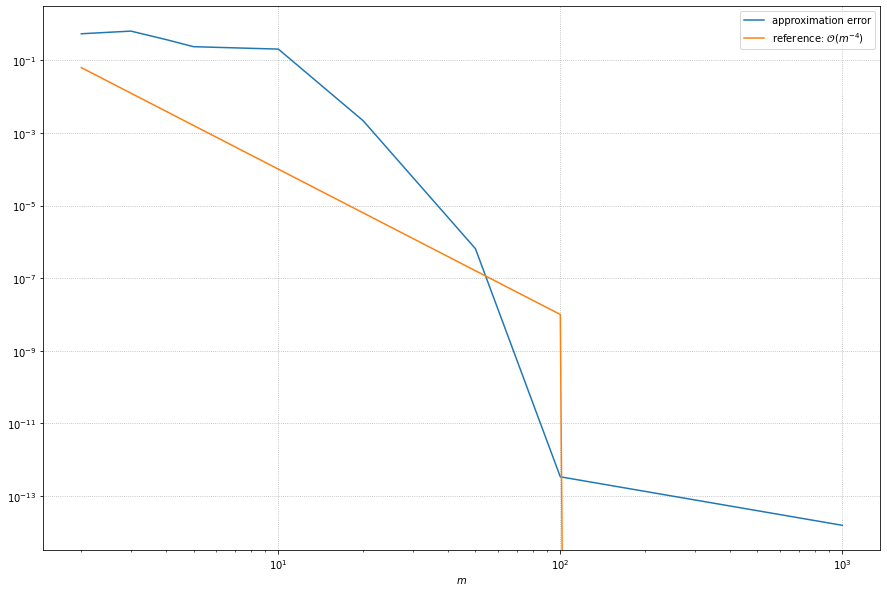

In [8]:
reference_order = 4
test_1_plot_error_array(m_array, error_array, reference_order)

## Hadeler Problem

\begin{gather}
    T(z) = (e^z - 1) B_1 + z^2 B_2 - B_0 \\
    B_0 = b_0 I, \quad B_1 = (b_{jk}^{(1)}), \quad B_2 = (b_{jk}^{(2)}) \\
    b_{jk}^{(1)} = (n + 1 - \max(j, k)) j k, \quad b_{jk}^{(2)} = n \delta_{jk} + 1 / (j + k)
\end{gather}

In [9]:
n = 200
b_0 = 100

In [10]:
b_1 = lambda j, k: (n + 1 - max(j, k)) * j * k
b_2 = lambda j, k: n * int(j == k) + 1 / (j + k)

B_0 = b_0 * np.eye(n)
B_1 = np.array([[b_1(j+1, k+1) for k in range(n)] for j in range(n)])
B_2 = np.array([[b_2(j+1, k+1) for k in range(n)] for j in range(n)])

T = lambda z: (np.exp(z) - 1) * B_1 + z ** 2 * B_2 - B_0

In [11]:
N = n

### Referenzwerte

Beim Test 1 haben wir die Referenzwerte explizit in der Hand gehabt.
Jetzt müssen wir diese semi-analytisch bestimmen.
Dazu schließen wir sie mit `integral_method` zunächst in eine hinreichend große Kurve ein.

In [12]:
j = 20
m = 200
R = 11.5
z = -30
tol = 1e-6

quadrature_nodes = [R * (omega(m) ** nu) + z for nu in range(m)]

eigen_values_approx = integral_method(T, N, j, m, R, z, tol)
eigen_values_fake   = integral_method(T, N, j, m, R, z, 0)

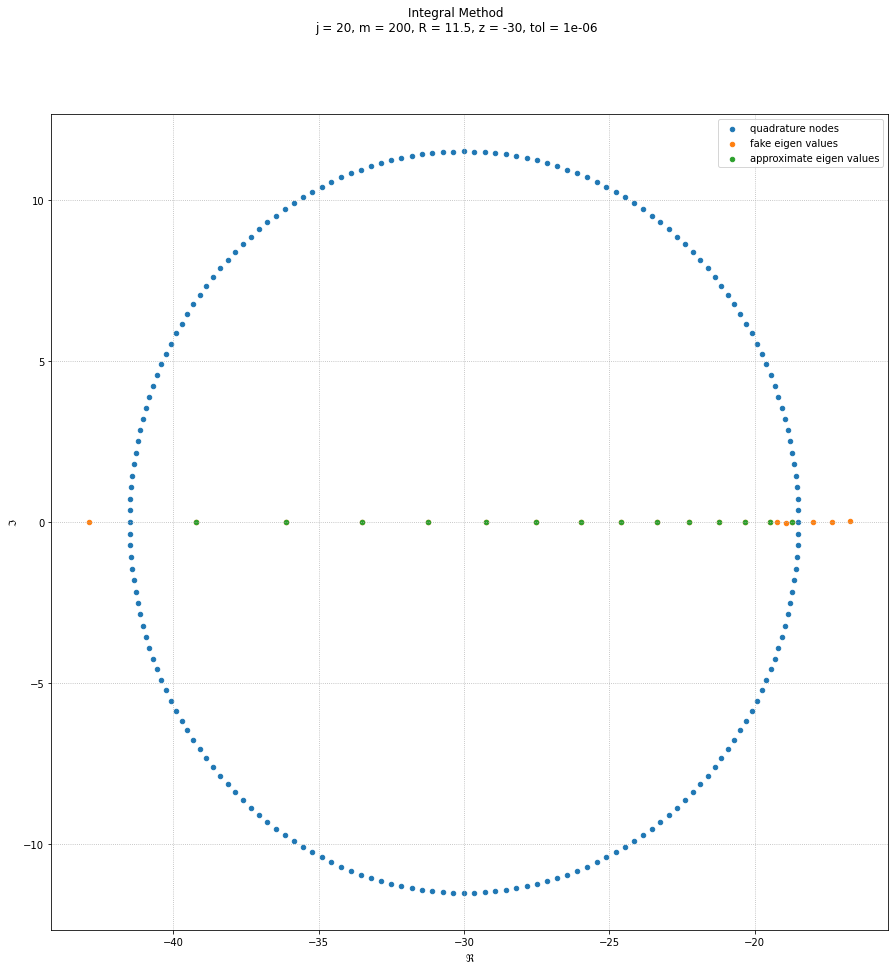

In [13]:
title = 'Integral Method' + '\n' + f'j = {j}, m = {m}, R = {R}, z = {z}, tol = {tol}'
legend = ('quadrature nodes', 'fake eigen values', 'approximate eigen values')

plot_complex(
    [quadrature_nodes, eigen_values_fake, eigen_values_approx],
    title, legend,
    size_dots = 20
)

Dann wenden wir `integral_method` auf die einzelnen Werte nochmal an, mit kleineren Kurven.

In [14]:
# we expecto only 1 eigen_value
j = 1

# we do not need that many quadrature nodes
m = 50

# make radius with smaller radius
# the center point z will be each eigen value
R = 0.1

# leave tolerance as it was
tol = 1e-6

eigen_values_ref = [
    integral_method(T, N, j, m, R, eigen_value, tol)[0]
    for eigen_value in eigen_values_approx
]

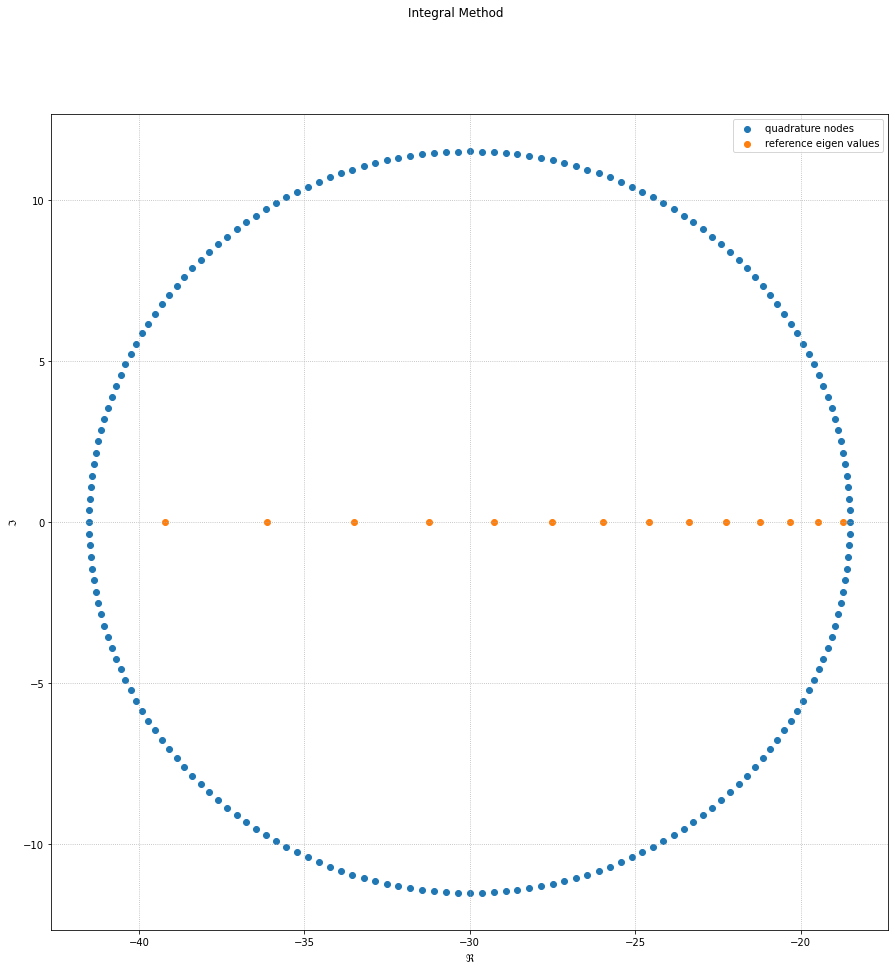

In [15]:
title = 'Integral Method'
legend = ('quadrature nodes', 'reference eigen values')

plot_complex(
    [quadrature_nodes, eigen_values_ref],
    title, legend
)

### Eigenwert überprüfen

Eine Heuristik, um Eigenwerte $\lambda$ zu identifizieren, d.h. ob $A(\lambda)$ singulär ist, besteht darin, die Konditionszahl zu betrachten.
Wenn diese sehr groß wird, dann ist $A(\lambda)$ (fast) singulär.

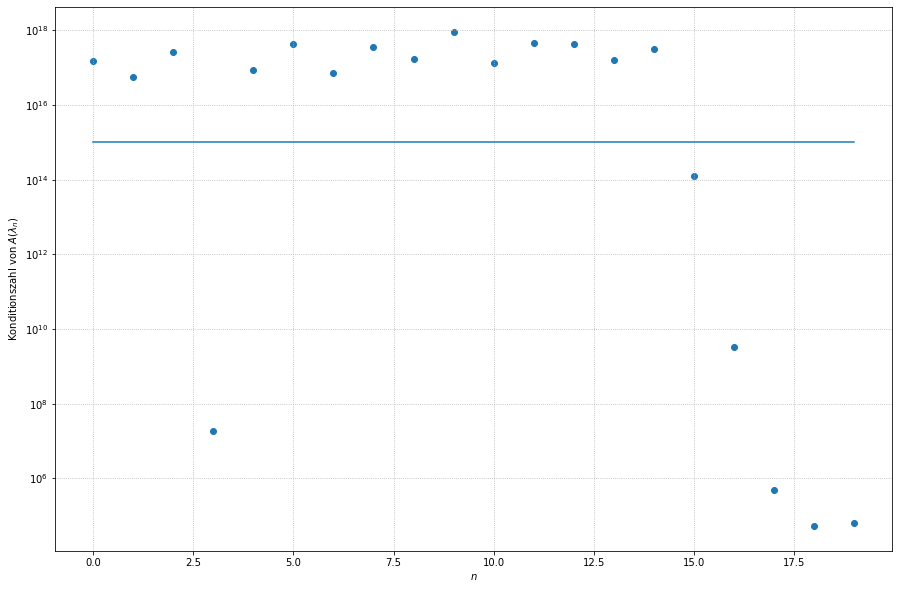

In [16]:
ax = plt.figure(figsize = (15, 10)).gca()

eigen_value_indices = range(len(eigen_values_fake))

ax.scatter(
    eigen_value_indices,
    [np.linalg.cond(T(ref)) for ref in eigen_values_fake]
)

ax.plot(
    eigen_value_indices,
    [1e15] * len(eigen_value_indices)
)

ax.grid(linestyle = ':')
ax.set_yscale('log')

ax.set_xlabel('$n$')
ax.set_ylabel('Konditionszahl von $A(\lambda_n)$')

plt.show()

Wir bekommen also scheinbar tatsächlich $14$ "echte" Eigenwerte (über der Abtrennung).

### Konvergenzplots

In [17]:
j = 15
m_array = [5, 10, 15, 20, 50, 100]
R_array = [9.5, 10.5, 11.5]
z = -30
tol = 1e-6

error_arrays = [
    [
        max([
            min([
                np.abs(eigen_value_approx - eigen_value_ref)
                for eigen_value_ref in eigen_values_ref
            ])
            for eigen_value_approx in integral_method(T, N, j, m, R, z, tol)
        ])
        for m in m_array
    ]
    for R in R_array
]

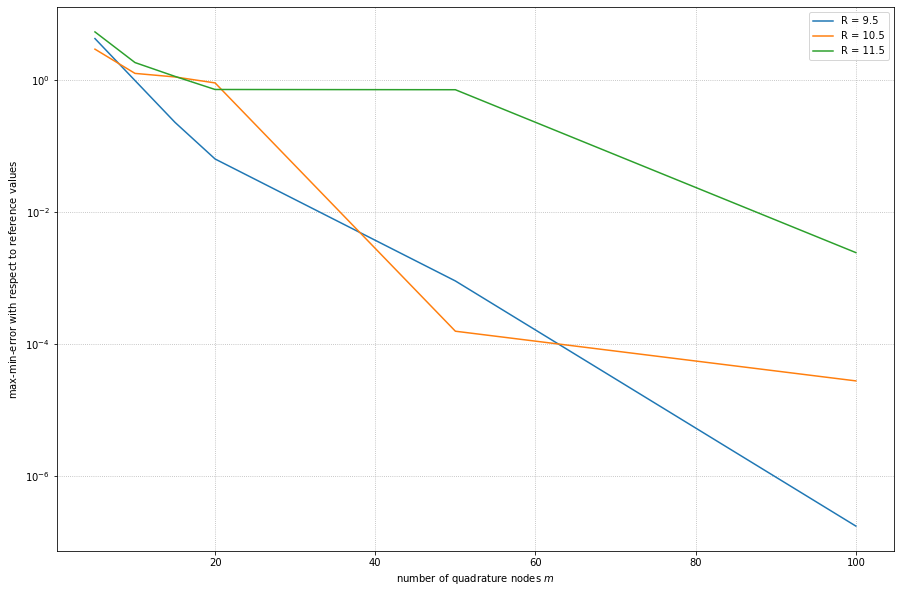

In [22]:
fig = plt.figure(figsize = (15, 10))

for error_array, R in zip(error_arrays, R_array):
    plt.semilogy(m_array, error_array, label = f'R = {R}')

plt.xlabel('number of quadrature nodes $m$')
plt.ylabel('$\max$-$\min$-error with respect to reference values')

plt.legend()
plt.grid(linestyle = ':')

fig.show()